In [1]:
import pandas as pd
import numpy as np
import itertools
import pprint
import re
import requests
import io
import time

import matplotlib.pyplot as plt
import seaborn as sns

from pymatgen import MPRester
from pymatgen.io.cif import CifBlock,CifFile
from pymatgen.core.structure import Structure
from pymatgen.core.lattice import Lattice

%matplotlib inline

/Users/mengzhao/miniconda2/envs/1_springboard_ds_track/lib/python3.6/site-packages/pymatgen/io/cif.py:37: UserWarning: Please install optional dependency pybtex if youwant to extract references from CIF files.
  warnings.warn("Please install optional dependency pybtex if you"


In [2]:
def file_lengthy(f):
    """ count the number of lines in file handle
    Parameters
    ----------
    f : file handle
        file to read from
    Returns
    -------
    num_lines : int
        returns the number of lines in the file.
    --------
    """   
    for i, l in enumerate(f):
        pass
    return int(i + 1)

def read_ase_xyz(fin):
    """ read a xyz file created using ASE from file handle
    Parameters
    ----------
    fin : file handle
        file to read from
    Returns
    -------
    lattice_vector: 3*3 numpy matrix
    coords: cartesian coordinates of the system natoms*3 array
    species: a list of elements in the system
    --------
    """
    # count the number of atoms
    natoms = file_lengthy(fin) - 6
    
    # cursor returns to the first line of file   
    fin.seek(0)
    
    # skip the first three lines in ase_xyz file
    next(fin)
    next(fin)
    next(fin)
    
    lattice_vector = np.zeros([3, 3], dtype="float64")
    
    for vector in lattice_vector:
        line = fin.readline().split()
        vector[:] = list(map(float, line[1:4]))

    coords = np.zeros([natoms, 3], dtype="float64")
    species = []
    for x in coords:
        line = fin.readline().split()
        species.append(line[4])
        x[:] = list(map(float, line[1:4]))

    return lattice_vector, coords, species

def read_pymatgen_cif(stringIO, natoms):
    """ read structure information from string with pymatgen cif format
    Parameters
    ----------
    stringIO : io.StringIO with pymatgen cif format
    Returns
    -------
    lattice_vector: 3*3 numpy matrix
    coords: cartesian coordinates of the system natoms*3 array
    species: a list of elements in the system
    --------
    """
    # count the number of atoms
    natoms = file_lengthy(stringIO) - 26
    
    # cursor returns to the first line of file   
    stringIO.seek(0)
    
    # skip the first three lines in pymatgen_cif file
    next(stringIO)
    next(stringIO)
    next(stringIO)

    a = float(stringIO.readline().split()[1])
    b = float(stringIO.readline().split()[1])
    c = float(stringIO.readline().split()[1])
    
    alpha = float(stringIO.readline().split()[1])
    beta = float(stringIO.readline().split()[1])
    gamma = float(stringIO.readline().split()[1])
    
    lattice_vector = Lattice.from_parameters(a, b, c, alpha, beta, gamma) 
    lattice_vector_matrix = lattice_vector._matrix
    
    # skip uncessary rows
    for i in range(1,18):
        next(stringIO)

    coords = np.zeros([natoms, 3], dtype="float64")
    species = []
    for x in coords:
        line = stringIO.readline().split()
        species.append(line[0])
        x[:] = list(map(float, line[3:6]))

    return lattice_vector_matrix, coords, species

# 1. gathering and wrangling datasets from NOMAD kaggle repository

In [3]:
start = time.time()

In [4]:
# data_k has 2400 entries in total without any missing value
data_k= pd.read_csv('./data_part1/data.csv')
data_k.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


In [5]:
# initialize three lists
materials_ids = []
stru_list = []
formulas = []

# convert the geometry.xyz data into a pymatgen structure object
for materials_id in data_k["id"]:
    with open("./data_part1/data/"+ str(materials_id) + "/geometry.xyz") as f:
        lattice_vector, coords, species = read_ase_xyz(f)

    materials_ids.append(materials_id)
    stru = Structure(lattice_vector, species, coords, coords_are_cartesian=True)
    formula = stru.composition.reduced_formula
    stru_list.append(stru)
    formulas.append(formula)

stru_df = pd.DataFrame({"id":materials_ids,
                        "structure":stru_list,
                        "formula":formulas
                      })

stru_df.head()

,id,structure,formula
0,1,"[[1.60888794 7.27641622 6.38315519] Ga, [6.584...",Al5(GaO4)3
1,2,"[[-0.06832433 -0.03390333 5.90667913] Al, [-0...",Al5(GaO4)3
2,3,"[[ 7.973323 -0.05220597 13.31342628] Ga, [ 4...",Al13(GaO8)3
3,4,[[-1.89997705e-03 2.34434405e-03 1.96210536e...,Al3InO6
4,5,"[[-0.01087285 -0.02978137 6.14523211] Ga, [-0...",In3Ga5O12


In [6]:
# join data_k and stru_df based on id

data_k_processed = data_k.merge(stru_df,on ='id')
data_k_processed.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev,structure,formula
0,1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,"[[1.60888794 7.27641622 6.38315519] Ga, [6.584...",Al5(GaO4)3
1,2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,"[[-0.06832433 -0.03390333 5.90667913] Al, [-0...",Al5(GaO4)3
2,3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,"[[ 7.973323 -0.05220597 13.31342628] Ga, [ 4...",Al13(GaO8)3
3,4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,[[-1.89997705e-03 2.34434405e-03 1.96210536e...,Al3InO6
4,5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,"[[-0.01087285 -0.02978137 6.14523211] Ga, [-0...",In3Ga5O12


In [7]:
# drop uncessary columns as structure objects in structure columns contains
# information on number of total atoms, percent of atoms, lattices vector, angles and so on

data_k_processed = data_k_processed[["formula","structure","spacegroup",
                                     "formation_energy_ev_natom",
                                     "bandgap_energy_ev"]]
data_k_processed.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
0,Al5(GaO4)3,"[[1.60888794 7.27641622 6.38315519] Ga, [6.584...",33,0.0680,3.4387
1,Al5(GaO4)3,"[[-0.06832433 -0.03390333 5.90667913] Al, [-0...",194,0.2490,2.9210
2,Al13(GaO8)3,"[[ 7.973323 -0.05220597 13.31342628] Ga, [ 4...",227,0.1821,2.7438
3,Al3InO6,[[-1.89997705e-03 2.34434405e-03 1.96210536e...,167,0.2172,3.3492
4,In3Ga5O12,"[[-0.01087285 -0.02978137 6.14523211] Ga, [-0...",194,0.0505,1.3793


# 2. gathering and wrangling datasets from materials project database 

In [8]:
api_key = " "

# initializes the REST adaptor. Put your own API key in.
a = MPRester(api_key)
 
# get entries for desired chemical systems
entries_1 = a.get_entries_in_chemsys(['Al','Ga','In','O',
                                    'Mo','Zr','W', 'Ta',
                                    'Sb','Zn','Sn','Ti',
                                    'Ce'])

entries_2 = a.get_entries_in_chemsys(['O','Fe','Co','Cu',
                                    'Ni','Mn','Pt','Pd',
                                    'Ir','Ru'])
entries = entries_1 + entries_2

# print(entries)
mp_ids = []
for entry in entries:    
    # considering metal oxides at least one metal element contained 
    if entry.composition.to_data_dict["nelements"] > 1 and 'O' in entry.composition.as_dict().keys():       
        mp_ids.append(entry.entry_id)

In [9]:
# initialize a list for storing detailed information of the entries
m = []
for mp_id in mp_ids:

    # get the relavent chemical properties based on the entires of interests
    mp_entry = requests.get("https://www.materialsproject.org/rest/v2/materials/"+
                             mp_id +"/vasp?API_KEY="+ api_key)
    
    mp_entry_json = mp_entry.json()
    m.append(mp_entry_json['response'][0])

In [10]:
# creates a pandas dataframe using response json data
r = pd.DataFrame(m)
r_materials = r[['material_id','spacegroup','pretty_formula',
                 'unit_cell_formula','cif','band_gap',
                 'formation_energy_per_atom']]

# extract the spacegroup number of the materials
r_materials['spacegroup'] = r_materials['spacegroup'].apply(lambda x: x['number'])

# extract number_of_total_atoms of the materials
r_materials['number_of_total_atoms'] = r_materials['unit_cell_formula'].apply(lambda x: sum(x.values()))

# rename the columns to be consistent with the data_part1 from kaggle
r_materials.rename(columns={'formation_energy_per_atom':'formation_energy_ev_natom',
                            'band_gap':'bandgap_energy_ev',
                            'material_id':'id'}, 
                            inplace=True)

r_materials.head()

/Users/mengzhao/miniconda2/envs/1_springboard_ds_track/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/mengzhao/miniconda2/envs/1_springboard_ds_track/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/mengzhao/miniconda2/envs/1_springboard_ds_track/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,id,spacegroup,pretty_formula,unit_cell_formula,cif,bandgap_energy_ev,formation_energy_ev_natom,number_of_total_atoms
0,mp-755066,14,Al2O3,"{'Al': 8.0, 'O': 12.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.2446,-3.353253,20.0
1,mp-759943,13,Al2O3,"{'Al': 32.0, 'O': 48.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.0646,-3.408777,80.0
2,mp-985587,150,Al2O3,"{'Al': 6.0, 'O': 9.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.8041,-3.231958,15.0
3,mp-684591,1,Al2O3,"{'Al': 16.0, 'O': 24.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,3.3433,-3.316400,40.0
4,mp-755483,160,Al2O3,"{'Al': 2.0, 'O': 3.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.0029,-3.350986,5.0


In [11]:
cif_string = r_materials['cif'].tolist()
mp_stru_list = []
materials_mp_ids = []

for index, cif_s in enumerate(cif_string):
    
    materials_mp_id = r_materials['id'][index]
    materials_mp_ids.append(materials_mp_id)
    
    natoms = r_materials['number_of_total_atoms'][index]
    
    cif_reading = io.StringIO(cif_s)
    lattice_vector,coords, species = read_pymatgen_cif(cif_reading, natoms)
    mp_stru = Structure(lattice_vector, species, coords, coords_are_cartesian=False)
    mp_stru_list.append(mp_stru)

mp_stru_df = pd.DataFrame({"id":materials_mp_ids,
                           "structure":mp_stru_list,
                         })
mp_stru_df.head()

,id,structure
0,mp-755066,"[[0.94638791 9.67633791 1.61587732] Al, [1.058..."
1,mp-759943,"[[0.01508342 2.92465689 5.9081223 ] Al, [ 5.57..."
2,mp-985587,"[[2.49414057 1.43998967 4.815885 ] Al, [0. ..."
3,mp-684591,[[4.88988743e+00 2.91169738e-03 5.65860178e+00...
4,mp-755483,[[ 9.61836066e-08 3.37636166e+00 -1.67414600e...


In [12]:
data_mp_processed = r_materials.merge(mp_stru_df,on ='id')
data_mp_processed.head()

,id,spacegroup,pretty_formula,unit_cell_formula,cif,bandgap_energy_ev,formation_energy_ev_natom,number_of_total_atoms,structure
0,mp-755066,14,Al2O3,"{'Al': 8.0, 'O': 12.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.2446,-3.353253,20.0,"[[0.94638791 9.67633791 1.61587732] Al, [1.058..."
1,mp-759943,13,Al2O3,"{'Al': 32.0, 'O': 48.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.0646,-3.408777,80.0,"[[0.01508342 2.92465689 5.9081223 ] Al, [ 5.57..."
2,mp-985587,150,Al2O3,"{'Al': 6.0, 'O': 9.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.8041,-3.231958,15.0,"[[2.49414057 1.43998967 4.815885 ] Al, [0. ..."
3,mp-684591,1,Al2O3,"{'Al': 16.0, 'O': 24.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,3.3433,-3.316400,40.0,[[4.88988743e+00 2.91169738e-03 5.65860178e+00...
4,mp-755483,160,Al2O3,"{'Al': 2.0, 'O': 3.0}",# generated using pymatgen\ndata_Al2O3\n_symme...,4.0029,-3.350986,5.0,[[ 9.61836066e-08 3.37636166e+00 -1.67414600e...


In [13]:
data_mp_processed =data_mp_processed[["pretty_formula","structure","spacegroup",
                                     "formation_energy_ev_natom",
                                     "bandgap_energy_ev"]]
data_mp_processed = data_mp_processed.rename(columns = {'pretty_formula':'formula'})
data_mp_processed.head()

,formula,structure,spacegroup,formation_energy_ev_natom,bandgap_energy_ev
0,Al2O3,"[[0.94638791 9.67633791 1.61587732] Al, [1.058...",14,-3.353253,4.2446
1,Al2O3,"[[0.01508342 2.92465689 5.9081223 ] Al, [ 5.57...",13,-3.408777,4.0646
2,Al2O3,"[[2.49414057 1.43998967 4.815885 ] Al, [0. ...",150,-3.231958,4.8041
3,Al2O3,[[4.88988743e+00 2.91169738e-03 5.65860178e+00...,1,-3.316400,3.3433
4,Al2O3,[[ 9.61836066e-08 3.37636166e+00 -1.67414600e...,160,-3.350986,4.0029


In [14]:
# concatenate two datasets data_k_processed and data_mp_processed together

frames = [data_k_processed,data_mp_processed]
data_complete = pd.concat(frames)

data_complete.head()
data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 0 to 1283
Data columns (total 5 columns):
formula                      3684 non-null object
structure                    3684 non-null object
spacegroup                   3684 non-null int64
formation_energy_ev_natom    3684 non-null float64
bandgap_energy_ev            3684 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 172.7+ KB


# 3. Data Exploration

Text(0.5, 1.0, 'Figure 1. boxplot of formation_energy_ev_natom and bandgap_energy_ev\n')

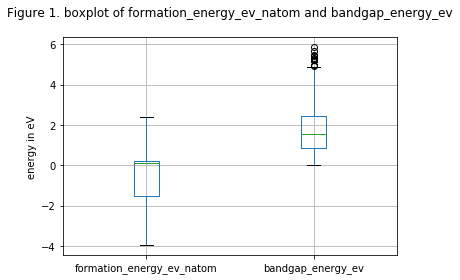

In [15]:
boxplot = data_complete.boxplot(column=['formation_energy_ev_natom',
                                        'bandgap_energy_ev'])
plt.ylabel("energy in eV")
plt.title("Figure 1. boxplot of formation_energy_ev_natom and bandgap_energy_ev\n")

In [16]:
end = time.time()
print("The data processing time is " + str((end-start)/3600) + " hours.")

The data processing time is 0.6536285497082605 hours.


# 4. Save Complete Dataset into a CSV File

In [17]:
# save the proceessed complete dataset into a csv file 
data_complete.to_csv("./data_complete.csv", sep=',') 

In [18]:
# save the proceessed dataset separately into a csv file 
data_k_processed.to_csv("./data_k_processed.csv", sep=',') 
data_mp_processed.to_csv("./data_mp_processed.csv", sep=',') 